In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
from analysis import * 
import matplotlib.pyplot as plt 

In [95]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [96]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [107]:
def resampling_data(df, feature = 'Load', resample_cost = 'h'):
    f = {'Hour': 'mean', 'Minutes': 'mean', feature: 'sum'}
    tmp = df.copy()
    df_day = tmp.set_index('Date').resample(resample_cost).agg(f)
    df_day.reset_index(drop=False, inplace=True)
    df_day['Day'] = df_day.Date.dt.day_of_week
    poland_holidays = holidays.CountryHoliday('Poland')
    df_day['Holiday'] = df_day.Date.apply(lambda x: x in poland_holidays)
    df_day['Day id'] = df_day.Date.dt.day_of_year
    peaks_up, _  = signal.find_peaks(df_day[feature], distance=5000)
    peaks_down, _  = signal.find_peaks(-df_day[feature], distance=5000)
    peaks = np.concatenate(([0], peaks_down, peaks_up, [len(df_day)-1]))
    df_day.loc[peaks, feature] = np.nan
    df_day[feature].interpolate(inplace=True)

    return df_day

df = resampling_data(Electric)

df = df[~df.Load.isna()].reset_index(drop=True)
df

,Date,Hour,Minutes,Load,Day,Holiday,Day id
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1
...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366


In [108]:
m, q = np.polyfit(x=df.index, y=df.Load, deg=1)
load_lin = m * df.index + q

df['Load_lin'] = load_lin
df['Load_detrend'] = df.Load - df['Load_lin']

df

,Date,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1,68781.328648,-7961.428648
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1,68781.407929,-10911.607929
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1,68781.487211,-13108.687211
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1,68781.566492,-13449.866492
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1,68781.645773,-14254.645773
...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366,75037.169791,-4646.869791
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366,75037.249072,-8112.149072
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366,75037.328354,-10137.228354
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366,75037.407635,-12017.607635


In [109]:
feature='Load_detrend'
cut_day='2016-12-22'

train_set = df[df.Date <= pd.to_datetime(cut_day, format='%Y-%m-%d')]
test_set = df[df.Date >= pd.to_datetime(cut_day, format='%Y-%m-%d')]
n_days_ahead = len(test_set.Date.dt.day_of_year.unique())

working_days = train_set[~train_set.Holiday].reset_index(drop=True)
festivities = train_set[train_set.Holiday].reset_index(drop=True)

f = {feature: ['mean', q1, q2], 'Load_lin': ['mean', q1, q2]}
pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)

Load_detrend                                  Load_lin  \
                     mean            q1            q2          mean   
Day id Hour                                                           
1      0.0  -11035.668141 -14019.008039  -7987.445744  71909.368141   
       1.0  -13119.623114 -16475.274983  -8545.449849  71561.878670   
       2.0  -16042.657951 -19227.114264 -11486.929130  71561.957951   
       3.0  -17839.026121 -21171.033546 -13671.788412  71562.037232   
       4.0  -18599.716514 -21834.252827 -14127.788995  71562.116514   
...                   ...           ...           ...           ...   
361    19.0  -3925.253108  -5036.380600  -2814.125617  70857.703108   
       20.0  -4535.532390  -5552.704881  -3518.359898  70857.782390   
       21.0  -6387.711671  -7512.044163  -5263.379179  70857.861671   
       22.0  -8554.640952  -9806.795944  -7302.485960  70857.940952   
       23.0 -12896.220233 -14376.185225 -11416.255241  70858.020233   

                                         
                       q1            q2  
Day id Hour                              
1      0.0   69599.193441  74219.542842  
       1.0   68920.609849  74202.259541  
       2.0   68920.689130  74202.338823  
       3.0   68920.768412  74202.418104  
       4.0   68920.847693  74202.497385  
...                   ...           ...  
361    19.0  69537.243117  72178.163100  
       20.0  69537.322398  72178.242381  
       21.0  69537.401679  72178.321663  
       22.0  69537.480960  72178.400944  
       23.0  69537.560241  72178.480225  

[1150 rows x 6 columns]

In [110]:
working_days

,Date,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
0,2008-01-02 00:00:00,0.0,22.5,57612.8,2,False,2,68783.152116,-11170.352116
1,2008-01-02 01:00:00,1.0,22.5,57091.2,2,False,2,68783.231397,-11692.031397
2,2008-01-02 02:00:00,2.0,22.5,56863.1,2,False,2,68783.310678,-11920.210678
3,2008-01-02 03:00:00,3.0,22.5,57093.4,2,False,2,68783.389959,-11689.989959
4,2008-01-02 04:00:00,4.0,22.5,57813.7,2,False,2,68783.469240,-10969.769240
...,...,...,...,...,...,...,...,...,...
75980,2016-12-21 20:00:00,20.0,22.5,96234.6,2,False,356,75018.142305,21216.457695
75981,2016-12-21 21:00:00,21.0,22.5,91167.9,2,False,356,75018.221586,16149.678414
75982,2016-12-21 22:00:00,22.0,22.5,84415.4,2,False,356,75018.300867,9397.099133
75983,2016-12-21 23:00:00,23.0,22.5,78352.5,2,False,356,75018.380148,3334.119852


In [48]:
def psf_forecasting(df, feature='Load_detrend', cut_day='2016-12-22'):
    train_set = df[df.Date <= pd.to_datetime(cut_day, format='%Y-%m-%d')]
    test_set = df[df.Date >= pd.to_datetime(cut_day, format='%Y-%m-%d')]
    n_days_ahead = len(test_set.Date.dt.day_of_year.unique())
    
    working_days = train_set[~train_set.Holiday].reset_index(drop=True)
    festivities = train_set[train_set.Holiday].reset_index(drop=True)
    
    f = {feature: ['mean', q1, q2], 'Load_lin': ['mean', q1, q2]}
    pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
    pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)    

    forecasting = []
    for day in pd.date_range(cut_day, periods=n_days_ahead, freq="d"):
        if any(day.day_of_year == festivities['Day id']):
            forecasting.append(pred_festivities.loc[day.day_of_year][feature].to_numpy())
        else:
            forecasting.append(pred_working_days.loc[day.day_of_week][feature].to_numpy())

    forecasting = np.concatenate(forecasting)
    days_forecasted = pd.date_range(cut_day, periods=n_days_ahead*24, freq="h")

    return train_set, test_set, forecasting, days_forecasted


In [84]:
def plot_psf_forecasting(date):
    plt.figure(figsize=(16, 12))
    date_mask = train_set.Date > date
    feature = 'Load_detrend'
    n = len(forecasting) - len(test_set)
    plt.plot(train_set.loc[date_mask, 'Date'], train_set.loc[date_mask, feature], label='Train_set')
    plt.plot(test_set['Date'], test_set[feature], color='green', label='Test_set')
    plt.plot(days_forecasted[:-n], forecasting[:-n, 0], color='orange', label='Predictions')
    plt.fill_between(x=days_forecasted[:-n], y1=forecasting[:-n, 1], y2=forecasting[:-n, 2], color='orange', alpha=0.5)
    plt.legend(fontsize=16)
    plt.title('Poland Electricity Load', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.grid()
    #plt.savefig('./Results/PSF_forecasting.png', transparent=True)

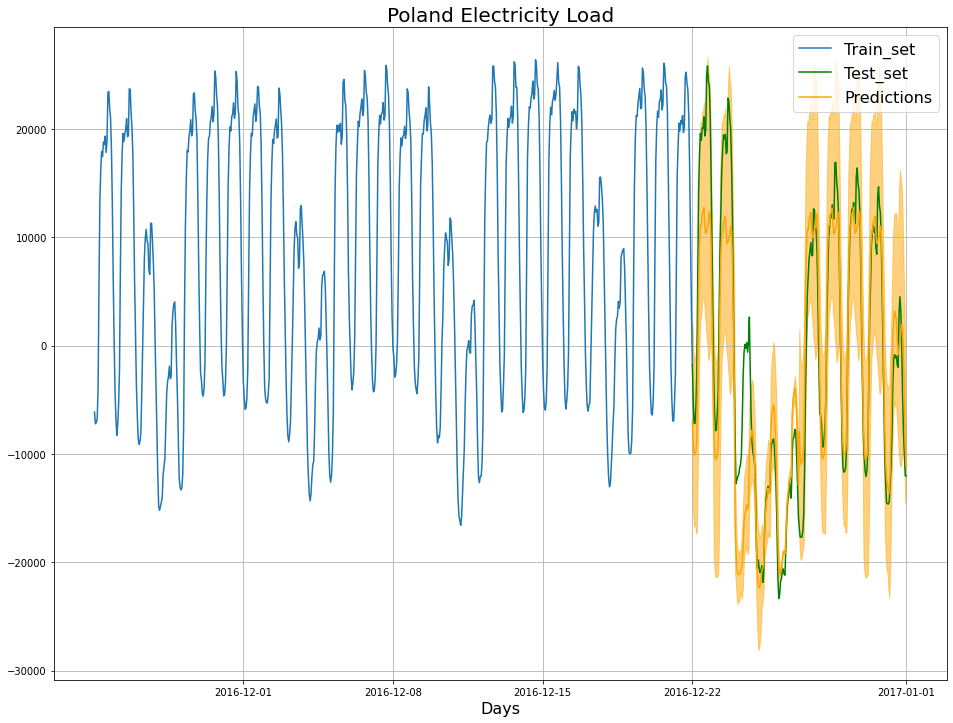

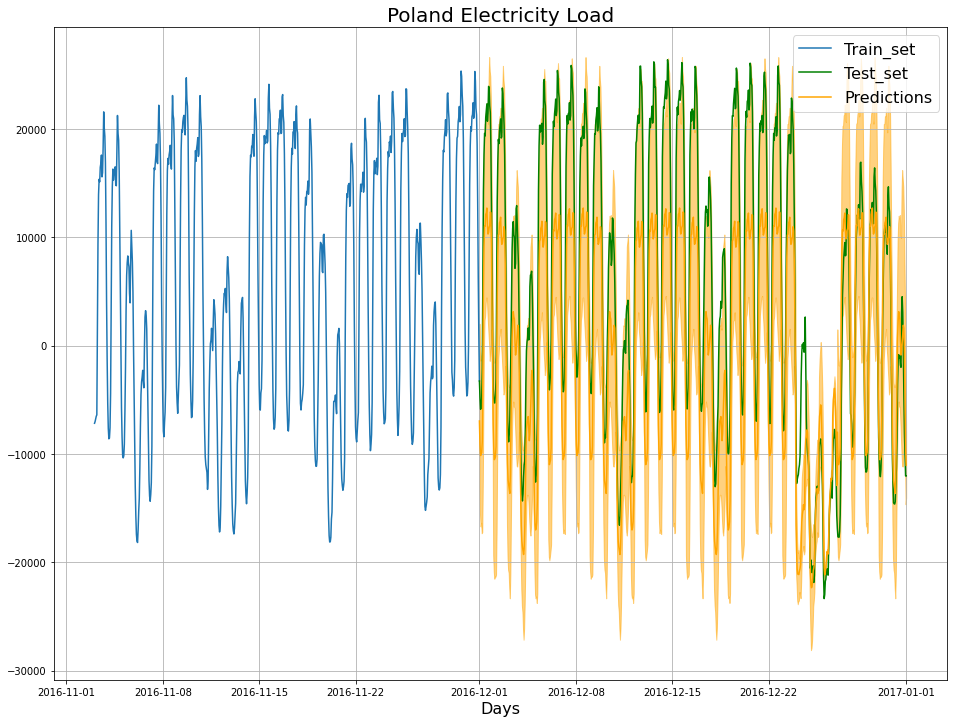

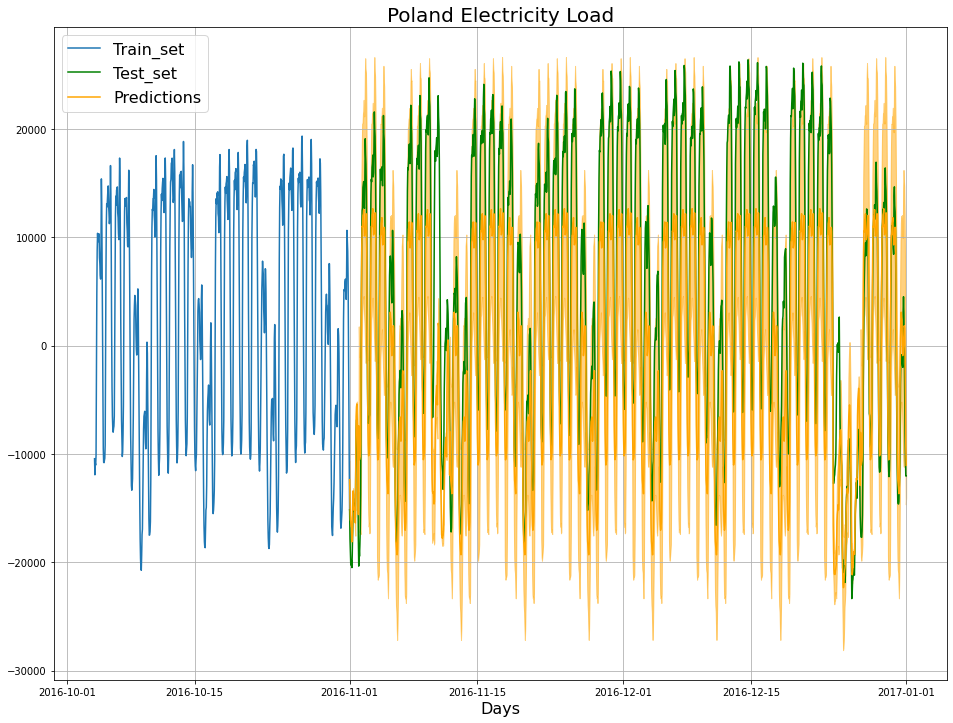

In [87]:
cut_dates = ['2016-12-22', '2016-12-01', '2016-11-01'] 

for cut_date in cut_dates:
    train_set, test_set, forecasting, days_forecasted = psf_forecasting(df, cut_day=cut_date)
    date = pd.to_datetime(cut_date) - dt.timedelta(weeks=4)
    plot_psf_forecasting(date)